<!-- # CNN autoencoder and Clustering from MTRX data

Use this notebook to load Scienta Omicron Matrix format SPM data and create standardised images for machine learning training and analysis. The code can generate both JPG image data, useful for manually checking the data, and windowed numpy data that can be loaded into ML models. 

The notebook then creates an autoencoder for training on a large dataset, followed by KMEANS clustering. 

**Author**: Steven R. Schofield  
**Created**: November, 2024 -->

# Machine learning autoencoder + Kmeans for STM image data analysis
## Steven R. Schofield (Universtiy College London) Dec. 2024.

### Load required modules

In [1]:
# Define path where to find the module. This allows for a different path depending on where the code is running (my mac or the cluster)
import os
import sys

# Define candidate paths
module_path_list = [
    '/Users/steven/academic-iCloud/Python/modules',
    '/hpc/srs/Python/modules'
]

data_path_list = [
    '/Users/steven/Python-data',
    '/hpc/srs/Python-data'
]

# Resolve actual paths
module_path = next((p for p in module_path_list if os.path.exists(p)), None)
data_path = next((p for p in data_path_list if os.path.exists(p)), None)

# Check and report missing paths
if module_path is None:
    print("Error: Could not locate a valid module path.")
if data_path is None:
    print("Error: Could not locate a valid data path.")

if module_path is None or data_path is None:
    sys.exit(1)

# Print resolved paths
print(f"module_path = {module_path}")
print(f"data_path = {data_path}")

# Reduce TensorFlow verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


module_path = /Users/steven/academic-iCloud/Python/modules
data_path = /Users/steven/Python-data


In [2]:
# # Ensure modules are reloaded 
%load_ext autoreload
%autoreload 2

# Import standard modules
import numpy as np

import platform

from datetime import datetime

# Add custom module path to list
sys.path.append(module_path)

# Import custom module
import SRSML24.data_prep as dp
import SRSML24.model as m
import SRSML24.utils as ut

import tensorflow as tf
#from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import pandas as pd
from IPython.display import display, Markdown

#import platform 

m.print_system_info()

start_time = dp.current_datetime()


Python version: 3.8.20 (default, Oct  3 2024, 10:22:23) 
[Clang 14.0.6 ]
TensorFlow version: 2.13.0
TensorFlow is built with CUDA: False
TensorFlow is built with ROCm: False

System: Darwin 24.3.0 (arm64)
Platform: macOS-15.3.2-arm64-arm-64bit
Processor: arm

Number of GPUs available to TensorFlow: 1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

>>> Running with GPU available <<<  (macOS-15.3.2-arm64-arm-64bit)

Current time 2025-04-22 20:11:34


### Programme variable setup

In [3]:
# Parameters for windows creation
# General
job_name = 'April_21_all'
verbose = False             # Set this True to print out more information

# MTRX preprocessing
flatten_method = 'poly_xy'
pixel_density = 15.0        # Convert all images to a constant pixel density
pixel_ratio = 0.7           # If an image has less than this % in the slow scan direction it is discarded
data_scaling = 1.e9         # Scale the z-height of the data

# Windowing
window_size = 32            # Window size for training/validation
window_pitch = 8            # Window pitch for training/validation

# Data saving options
save_windows = True         # Save the windows as numpy files
together = True             # Set this True to save image windows for a mtrx image as a single file rather than separate files.
save_jpg = False            # Save the full image as a jpg
collate = False             # Set this True to remove all subfolder directories and save all data in root data path
save_window_jpgs = False    # Save the windows as jpgs for inspection

# Parameters for training
model_name = 'unet_' + job_name
batch_size = 128
buffer_size = 12800 # shuffling
learning_rate = 1e-4
epochs = 5

# Parameters for clustering
cluster_model_name = model_name + '_kmeans'
cluster_batch_size = 5120 # This is the number of latent features in a batch for clustering. 
                          # Does not have to be the same as for training and probably should 
                          # be larger. 
cluster_buffer_size = cluster_batch_size * 5    # shuffling buffer
num_clusters=20                                 # Desired number of clusters (centroids) to form in the data.
max_iter=1000                                   # Maximum iterations allowed for each mini-batch to refine centroids.
reassignment_ratio=0.05                         # Fraction of clusters reassigned per step; lower values stabilize updates.

# Parameters for PREDICTIONS
predict_window_pitch = 2                        # Window pitch for prediction
predictions_batch_size = 2**15                  # Batch size for predictions


# DATA LIMITS FOR TESTING THE CODE
mtrx_train_data_limit = None                    # Number of MTRX files to process (training)
mtrx_test_data_limit = None                     # Number of MTRX files to process (validation)

train_data_limit = None                         # Limit the data used in the autoencoder training
test_data_limit = None                          # Limit the data used in the autoencoder training (validation)

In [4]:
job_data_path = dp.create_new_data_path(data_path, job_name, include_date=False)

mtrx_train_path = os.path.join(data_path, 'mtrx/train')
mtrx_test_path = os.path.join(data_path, 'mtrx/test')
mtrx_predict_path = os.path.join(data_path, 'mtrx/predict')

model_path = os.path.join(job_data_path,'model')
cluster_model_path = os.path.join(job_data_path,'cluster_model')

latent_features_path = os.path.join(job_data_path, 'latent_features')
predict_latent_features_path = os.path.join(job_data_path, 'latent_features_predictions')

windows_train_path = os.path.join(job_data_path, 'windows/train')
windows_test_path = os.path.join(job_data_path, 'windows/test')
windows_predict_path = os.path.join(job_data_path, 'windows/predict')

predictions_path = os.path.join(job_data_path, f'predictions')

### Process Matrix format data to windows for autoencoder training and validation

In [5]:
# REMOVE ALL DATA FOLDERS EXCEPT MTRX 
dp.delete_data_folders(job_data_path, subdirectories=["jpg", "windows", "windows-jpg"], override=True)

No target folders found to delete.


In [6]:
# Training data
mtrx_train_file_list, _ = dp.list_files_by_extension(mtrx_train_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_train_file_list[0:mtrx_train_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
    )

# Test data
mtrx_test_file_list, _ = dp.list_files_by_extension(mtrx_test_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_test_file_list[0:mtrx_test_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
    )

Found 1973 files with extension 'Z_mtrx' in directory:
/Users/steven/Python-data/mtrx/train
There are 1973 files to process
....t...t....t....................t.t............ttt.......t.......t.....ttt.t............tt..tttt. 100
t........t......ttt..t..tt.ttt.........t..t....tt.t.tt..tt...tttttttttttttttttttttt.ttt.ttt.tt..ttt 200
tt..t..tttt...tt.tttt.t.t.tttttttt.t.tt.tt.t..t.tt..t.......t.t....ttt...........ttt........t...t... 300
t....t.............t...............tt..................t........t......ttt.ttt...t....t..t.t....t.t 400
........tttttttttttttt...tttttttttttt........t........ttttttt....tttt.tt.......ttttt.t............. 500
.t.t.t.t..................t....tttttttttt.tt....t.t.t..ttt.t.t...t.t.t.t.t..t..t.t.t..t..t.t.t.t... 600
tt..t..t.tt.t..t.t.t.t.t.t..t..t....tt.t.t..t......................t..t.t.......................... 700
.....tt.t..ttttt.........t.....tt.....t..t..t.tt.t....tt...tt..t.......t.t...t..................... 800
..................ttt..........tt...tttttt

### Build tensorflow data pipeline for training and validation of autoencoder

In [7]:
# Training data - tensorflow data pipeline for autoencoder
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

# Create dataset with prefetching
train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

# Validation data - tensorflow data pipeline for autoencoder
test_files, num_test = dp.list_files_by_extension(windows_test_path, 'npy')
test_files = test_files[:test_data_limit]

# Create dataset with prefetching
test_dataset = m.create_tf_dataset_batched(
    test_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

Found 1460 files with extension 'npy' in directory:
/Users/steven/Python-data/April_21_all/windows/train
Data pipeline created with 1460 files, batch size: 128, window size: 32
Sample batch shape: (128, 32, 32, 1)

Found 282 files with extension 'npy' in directory:
/Users/steven/Python-data/April_21_all/windows/test
Data pipeline created with 282 files, batch size: 128, window size: 32
Sample batch shape: (128, 32, 32, 1)



In [8]:
# Build and compile the UNET model
autoencoder_model = m.build_autoencoder(window_size=window_size,model_name=model_name)
autoencoder_model.summary()
m.save_model_summary(autoencoder_model, model_path, model_name=model_name)

# Can also save a graphical representation of the model
# This requires pydot and graphviz to be installed
# pip install pydot
# pip install graphviz
# If you are using a Mac, you may need to install graphviz using brew
# brew install graphviz
m.save_model_diagram(autoencoder_model, model_path, model_name=model_name, show_shapes=False, show_layer_names=False, expand_nested=False)

# Check if running on Apple Silicon
is_mac_silicon = platform.system() == "Darwin" and platform.processor() == "arm"

if is_mac_silicon:
    print("Detected Mac with Apple Silicon. Compiling the model with the legacy RMSprop optimizer for compatibility with TensorFlow-metal.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )
else:
    print("Compiling the model with the RMSprop optimizer.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )



Model: "unet_April_21_all"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 32)           320       ['input[0][0]']               
                                                                                                  
 drop1 (Dropout)             (None, 32, 32, 32)           0         ['conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 16, 16, 32)           0         ['drop1[0][0]']               
                                                                                  

### Train autoencoder

In [9]:
# Train the model using the tf.data datasets
history = autoencoder_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1
)
model_train_time = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f"Model training completed at {model_train_time}")

# Save the model as soon as training completes
m.save_model(autoencoder_model, model_path, model_name=model_name, model_train_time=model_train_time)

end_time = dp.current_datetime()
dp.elapsed_time(start_time,end_time)

Epoch 1/5
38070/38070 [==============================] - 2323s 61ms/step - loss: 2.4367e-04 - mse: 2.4367e-04 - mae: 0.0075 - val_loss: 3.2672e-04 - val_mse: 3.2672e-04 - val_mae: 0.0126
Epoch 2/5
38070/38070 [==============================] - 2315s 61ms/step - loss: 1.1553e-05 - mse: 1.1553e-05 - mae: 0.0027 - val_loss: 2.4208e-04 - val_mse: 2.4208e-04 - val_mae: 0.0097
Epoch 3/5
38070/38070 [==============================] - 2305s 61ms/step - loss: 7.6621e-06 - mse: 7.6621e-06 - mae: 0.0022 - val_loss: 1.7805e-04 - val_mse: 1.7805e-04 - val_mae: 0.0075
Epoch 4/5
38070/38070 [==============================] - 2242s 59ms/step - loss: 5.9808e-06 - mse: 5.9808e-06 - mae: 0.0020 - val_loss: 1.2065e-04 - val_mse: 1.2065e-04 - val_mae: 0.0054
Epoch 5/5
38070/38070 [==============================] - 2270s 60ms/step - loss: 4.9431e-06 - mse: 4.9431e-06 - mae: 0.0018 - val_loss: 1.0440e-04 - val_mse: 1.0440e-04 - val_mae: 0.0059
Model training completed at 20250422_192909
Model saved at: /User

The training history data has been saved to disk as a binary pickle file in: /Users/steven/Python-data/April_21_all/model/unet_April_21_all_20250422_192909_history_data.dat


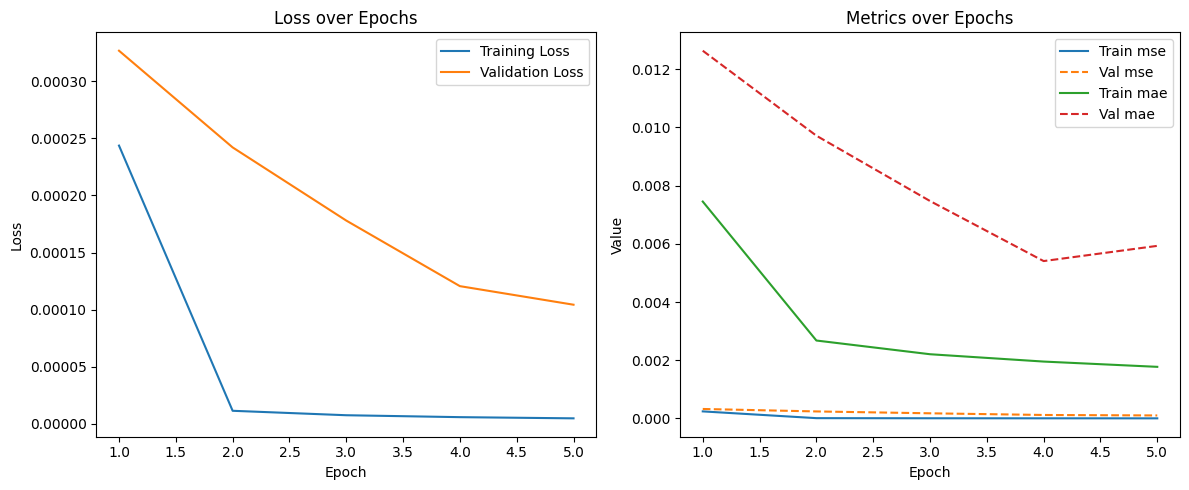

'/Users/steven/Python-data/April_21_all/model/unet_April_21_all_20250422_192909_history_data.jpg'

In [10]:
# Save training history
history_data_file_path = m.save_history(history, model_path=model_path, model_name=model_name, model_train_time=model_train_time)
#history_data_file_path=model_path+'/'+model_name+'_'+model_train_time+'_history_data.dat'
m.plot_history_from_file(file_path=history_data_file_path,
                            loss_name='loss', 
                            val_loss_name='val_loss', 
                            metric_names=['mse', 'mae'], 
                            val_metric_names=['val_mse', 'val_mae'],
                            dpi=150,
                            show_plot=True)

### Extract Latent Features

In [11]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories='latent_features',
    override=True)

No target folders found to delete.


In [12]:
# Load the trained autoencoder model
autoencoder_model = m.load_model(model_path, model_name=model_name)

Model loaded from: /Users/steven/Python-data/April_21_all/model/unet_April_21_all.keras


In [13]:
# Training data - tensorflow data pipeline 
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=cluster_batch_size, 
    buffer_size=cluster_buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

Found 1460 files with extension 'npy' in directory:
/Users/steven/Python-data/April_21_all/windows/train
Data pipeline created with 1460 files, batch size: 5120, window size: 32
Sample batch shape: (5120, 32, 32, 1)



In [14]:
m.extract_latent_features_to_disk_from_prebatched_windows(
    autoencoder_model, 
    train_dataset, 
    latent_features_path, 
    bottleneck_layer_name='bottleneck',
    features_name='latent_features_train',
    return_array=False,
    verbose=False)

....................................................................................................100
...................................................................................................200
...................................................................................................300
...................................................................................................400
...................................................................................................500
...................................................................................................600
...................................................................................................700
...................................................................................................800
...................................................................................................900
...................................................
All latent features 

### Train KMEANS using latent features saved to disk

In [5]:
# List and sort latent feature files
latent_features_files, num_latent_files = dp.list_files_by_extension(latent_features_path, 'npy')

Found 952 files with extension 'npy' in directory:
/Users/steven/Python-data/April_21_all/latent_features


In [6]:
# Load the latent features from disk into a tensor dataset pipeline
latent_features_dataset = m.create_latent_features_tf_dataset(
    latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=True, 
    shuffle_buffer_size=cluster_buffer_size)

Data pipeline created with 952 files, batch size: 5120
Shuffling enabled with buffer size: 25600
Batch shape: (5120, 4096)


Batch 1 processed. Inertia: 548.402099609375
Batch 2 processed. Inertia: 530.7574462890625
Batch 3 processed. Inertia: 542.207275390625
Batch 4 processed. Inertia: 559.1278076171875
Batch 5 processed. Inertia: 547.5617065429688
Batch 6 processed. Inertia: 531.3783569335938
Batch 7 processed. Inertia: 525.1444091796875
Batch 8 processed. Inertia: 520.8560791015625
Batch 9 processed. Inertia: 538.0900268554688
Batch 10 processed. Inertia: 552.0277099609375
Batch 11 processed. Inertia: 532.1976318359375
Batch 12 processed. Inertia: 506.1382751464844
Batch 13 processed. Inertia: 528.070556640625
Batch 14 processed. Inertia: 519.987060546875
Batch 15 processed. Inertia: 538.885986328125
Batch 16 processed. Inertia: 537.4378051757812
Batch 17 processed. Inertia: 539.8023681640625
Batch 18 processed. Inertia: 531.0343017578125
Batch 19 processed. Inertia: 507.4749450683594
Batch 20 processed. Inertia: 527.094970703125
Batch 21 processed. Inertia: 522.3304443359375
Batch 22 processed. Inertia:

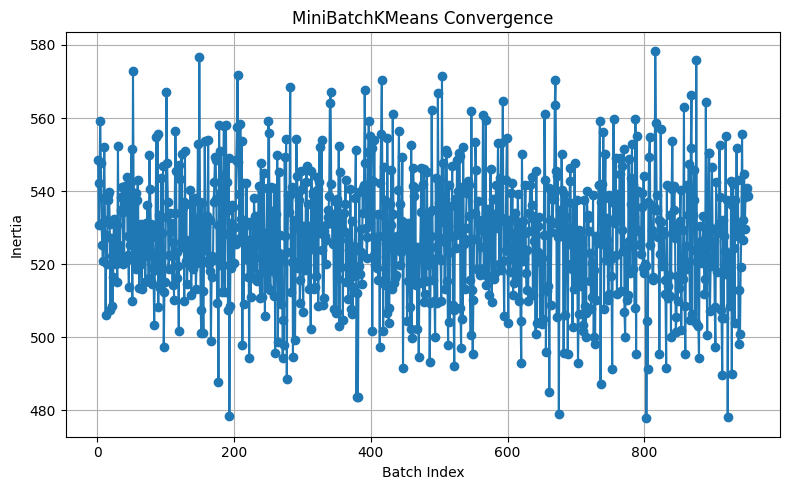

Cluster model saved at: /Users/steven/Python-data/April_21_all/cluster_model/unet_April_21_all_kmeans.pkl


In [7]:

cluster_model, convergence_history = m.train_kmeans(
    latent_features_dataset,                # tf.data.Dataset containing batches of latent feature vectors.
    batch_size=cluster_batch_size,          # Size of each batch for the KMeans model (controls memory usage and stability).
    num_clusters=num_clusters,              # Desired number of clusters (centroids) to form in the data.
    max_iter=5000000,                      # Maximum iterations allowed for each mini-batch to refine centroids.
    reassignment_ratio=0.01   # Fraction of clusters reassigned per step; lower values stabilize updates.
)
# Save and plot convergence history
m.plot_kmeans_convergence(convergence_history, cluster_model_path, model_name=cluster_model_name)

# Save cluster model
m.save_cluster_model(cluster_model, cluster_model_path, model_name=cluster_model_name)

### Process Matrix format data to windows for making predictions 

In [8]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories=['windows/predict','windows-jpg/predict','jpg/predict'],
    override=True)

No target folders found to delete.


In [9]:
# Prediction data in MTRX format
mtrx_predict_file_list, _ = dp.list_files_by_extension(mtrx_predict_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_predict_file_list,
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, 
    window_pitch = predict_window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
)

Found 9 files with extension 'Z_mtrx' in directory:
/Users/steven/Python-data/mtrx/predict
There are 9 files to process
ttttttttt
********************
Conversion complete.
********************



### Make predictions using the trained autoencoder and KMEANS models

In [10]:
# Load the trained autoencoder
autoencoder_model = m.load_model(model_path, model_name=model_name)

# Load a previously saved cluster model from disk
cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)

Model loaded from: /Users/steven/Python-data/April_21_all/model/unet_April_21_all.keras
Cluster model loaded from: /Users/steven/Python-data/April_21_all/cluster_model/unet_April_21_all_kmeans.pkl


In [11]:
# Get the list of image windows files to make predictions on
predict_data_files_list, predict_data_files_num = dp.list_files_by_extension(windows_predict_path,'.npy',verbose=False)
# Get the corresponding image coordimages list file
image_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_predict_path,'.txt',verbose=False)
image_windows_coordinates_file_list = [
    name for name in image_windows_coordinates_file_list 
    if "coordinates" in name
]

Found 32 files with extension '.npy' in directory:
/Users/steven/Python-data/April_21_all/windows/predict
Found 64 files with extension '.txt' in directory:
/Users/steven/Python-data/April_21_all/windows/predict


In [12]:
ut.summarize_parameters(['job_name', 'flatten_method', 'pixel_density', 'pixel_ratio', 'data_scaling', 'window_size', 
                      'window_pitch', 'model_name', 'model_train_time', 'batch_size', 'buffer_size', 'learning_rate', 
                      'epochs', 'cluster_model_name', 'cluster_batch_size', 'cluster_buffer_size', 'num_clusters', 
                      'max_iter', 'reassignment_ratio', 'predict_window_pitch', 'mtrx_train_data_limit', 
                      'mtrx_test_data_limit', 'train_data_limit', 'test_data_limit',], save_path=predictions_path)


Saved parameter summary to /Users/steven/Python-data/April_21_all/predictions/parameter_summary_20250422_201503.csv


,Parameter,Value
0,job_name,April_21_all
1,flatten_method,poly_xy
2,pixel_density,15.0
3,pixel_ratio,0.7
4,data_scaling,1000000000.0
5,window_size,32
6,window_pitch,8
7,model_name,unet_April_21_all
8,model_train_time,undefined
9,batch_size,128


In [16]:

# Make predictions on the image windows and save the latent features to disk
for prediction_file, coords_file in zip(predict_data_files_list,image_windows_coordinates_file_list):
    # Load the windows for the image as a numpy file
    image_windows = np.load(prediction_file)
    # Load the image window coordinates
    image_windows_coordinates = dp.load_coordinates_file(coords_file)
    # Reconstruct the original image from the loaded image windows
    reconstructed_img = dp.reconstruct_image(image_windows,image_windows_coordinates,window_size)
    
    # Make a tensorflow data pipeline of just the image windows for this image.
    num_windows = image_windows.shape[0]
    print('\n---\nProcessing file {}'.format(os.path.basename(prediction_file)))
   
    # Predictions windows
    predict_dataset = m.create_tf_dataset_batched(
        [prediction_file], 
        batch_size=predictions_batch_size, 
        window_size=window_size,
        is_autoencoder=False, 
        shuffle=False)
   
    # make the latent features for each window using the autoencoder model 
    latent_predict_features, num_latent_predictions = m.extract_latent_features_to_disk_from_prebatched_windows(
        autoencoder_model, 
        predict_dataset, 
        '',                 # we are not saving these predictions to disk so don't need a folder or name
        features_name='',
        return_array=True,
        verbose=False)
    
    # make preductions 
    cluster_predictions = cluster_model.predict(latent_predict_features)
    
    # Build the reconstruction of the predicted cluster label data
    cluster_img = dp.reconstruct_cluster_image(image_windows_coordinates,window_size, cluster_predictions)
    
    # Pad the cluster image to the original image size
    cluster_img = ut.padded_cluster_img = ut.pad_cluster_image(reconstructed_img,cluster_img,window_size)
    image_name = os.path.splitext(os.path.basename(prediction_file))[0]
  
  #  label_stats, background_labels = m.analyse_cluster_labels(cluster_img, large_region_thresh=0.005)
  #  cluster_img = m.relabel_background(cluster_img, background_labels)

    # Save the cluster image to disk
    m.display_reconstructed_and_cluster_images(reconstructed_img,cluster_img,
                                                show_overlay=True,
                                                save_to_disk=True,
                                                output_path=predictions_path,
                                                image_name=image_name,
                                                dpi=150)  
    


---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)
......Combined latent features shape: (189225, 4096)
Directory created: /Users/steven/Python-data/April_21_all/predictions
Image saved to /Users/steven/Python-data/April_21_all/predictions/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_all_windows.jpg with dpi=150

---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BU_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)
......Combined latent features shape: (189225, 4096)
Image saved to /Users/steven/Python-data/April_21_all/predictions/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BU_all_windows.jpg with dpi=150

---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_wi

In [14]:
# data = cluster_img

# # Function to display pixel values on click
# def on_click(event):
#     # Check if the click is on the image
#     if event.inaxes:
#         # Get the row and column indices
#         col, row = int(event.xdata + 0.5), int(event.ydata + 0.5)
#         # Get the pixel value
#         pixel_value = data[row, col]
#         print(f"Clicked on ({row}, {col}) with value: {pixel_value}")

# # Plot the image
# fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
# cax = ax.imshow(data, cmap='viridis', interpolation='nearest')
# fig.colorbar(cax, ax=ax)
# ax.set_title("Click on the image to get pixel value")

# # Connect the click event to the function
# cid = fig.canvas.mpl_connect('button_press_event', on_click)

# # Show the plot
# plt.show()


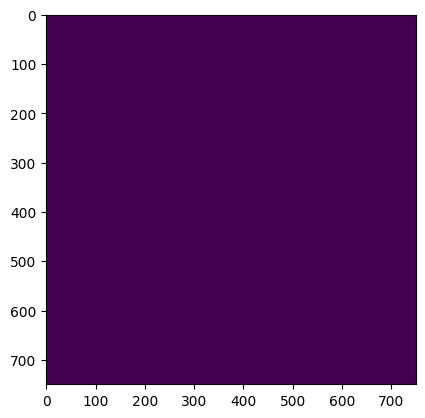

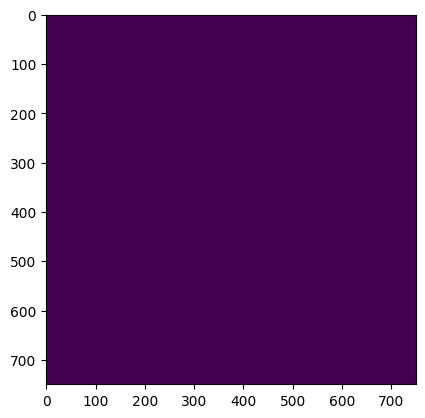

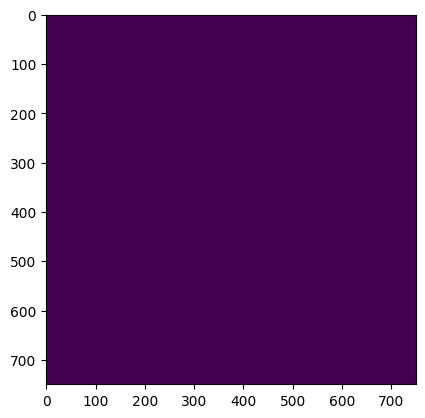

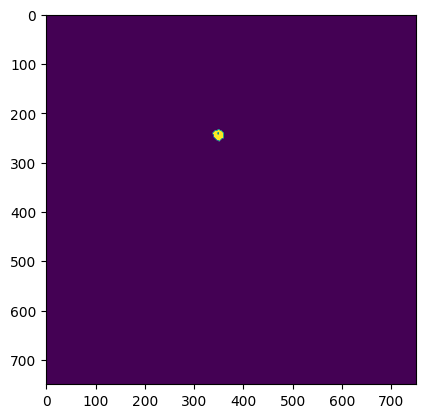

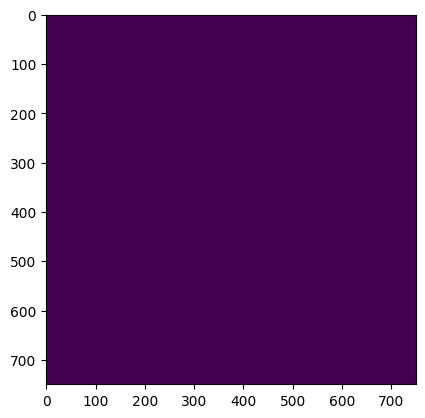

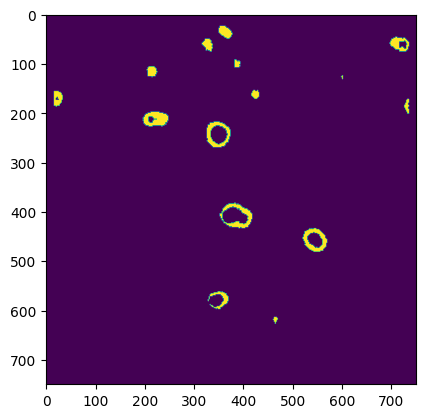

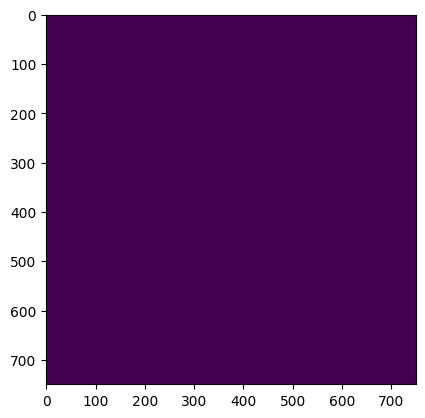

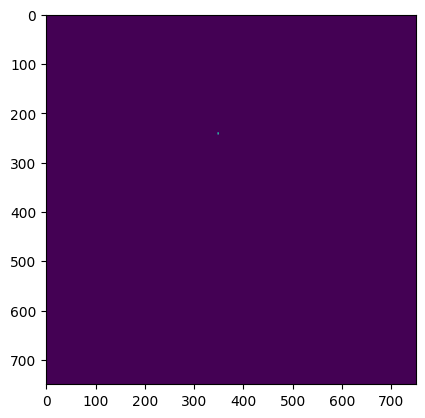

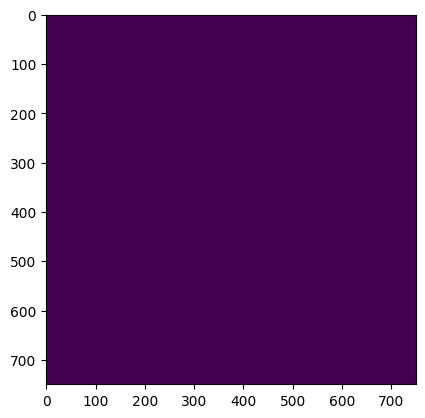

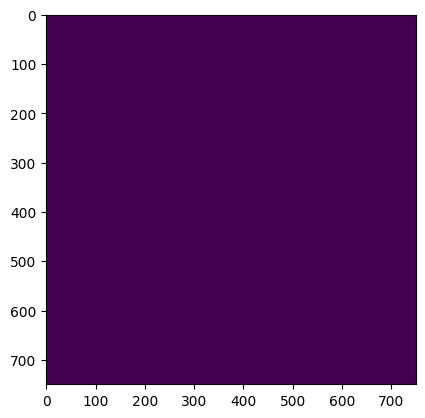

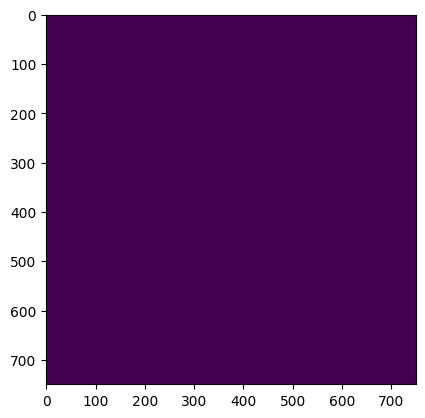

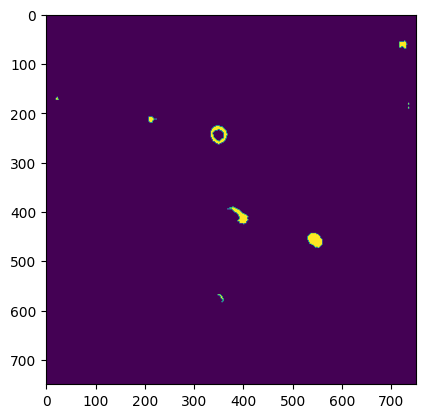

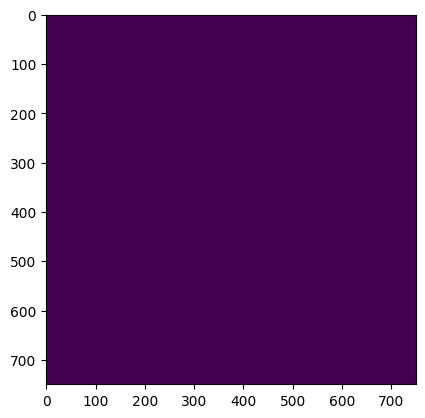

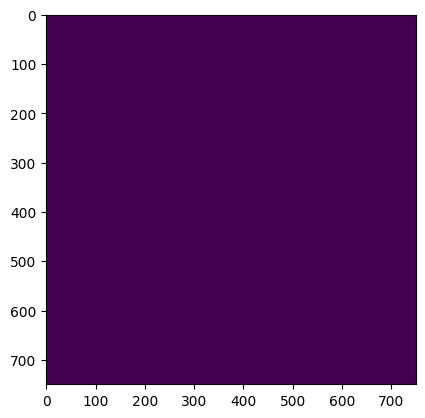

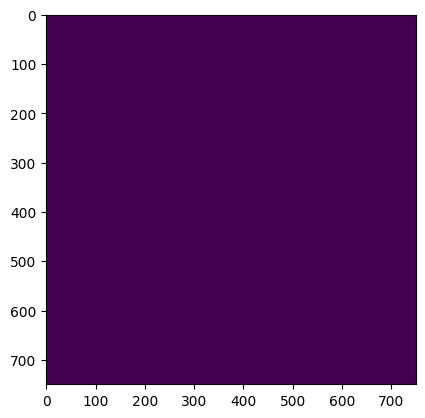

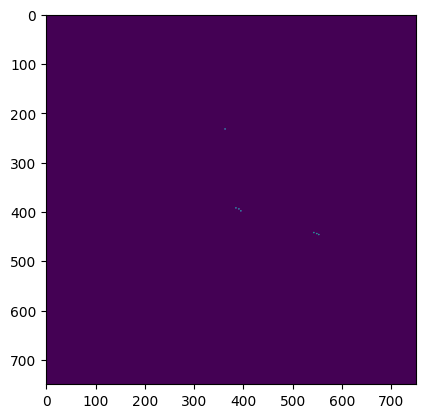

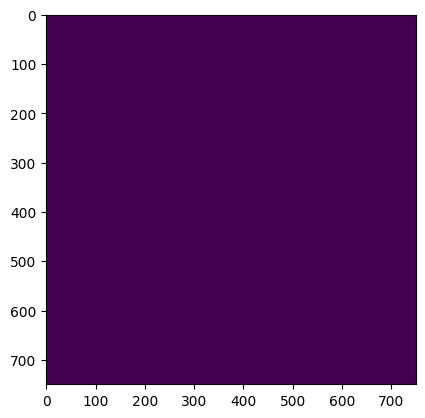

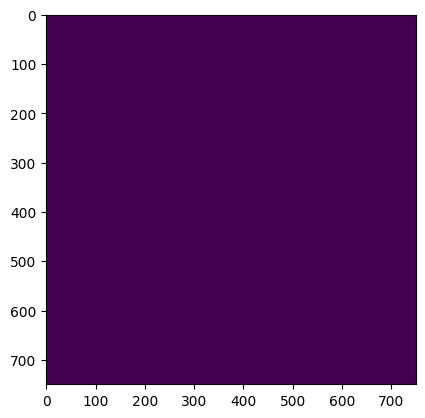

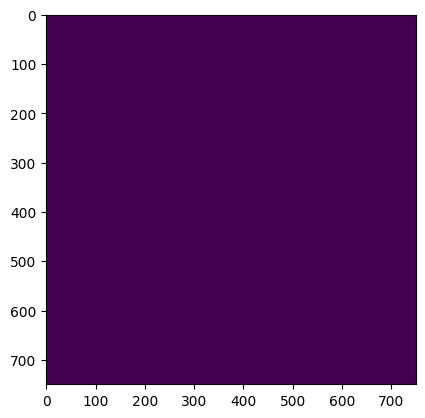

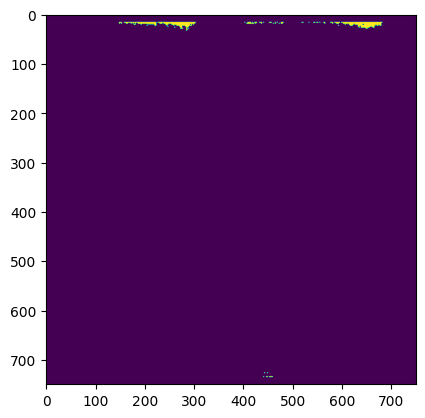

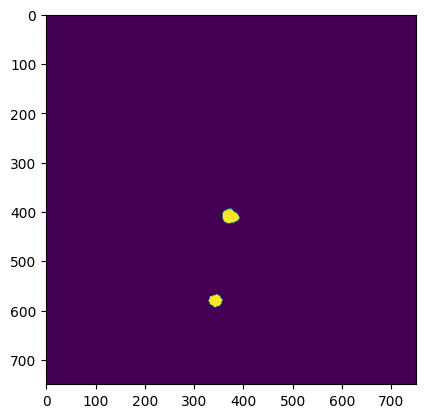

In [15]:
for i in range(int(np.max(cluster_img))+1):
    plt.imshow(cluster_img==i, cmap='viridis')
    plt.show()